In [ ]:
class node:
    def __init__(self,prevSplit,depth,X,y):
        self.depth = depth
        self.left = None
        self.right = None
        self.prevSplit = prevSplit
        self.X = X
        self.y = y
        self.thresh = None
        self.SplitFeature = None
        self.value = None
        self.Splitfeatureindex = None

class DecisionTreeClassifier:
    def __init__(self,max_depth):
        self.max_depth = max_depth
        self.root = None
    
#     --------------------------------------------------------------------------
#     helper functions for making good choice of split
    def giniofnode(self,l):
#     l is a 1 d list
        total = np.sum(l)
        gini = 1
        for i in l :
            gini = gini + (-((i/total)**2))
        return gini
# sum of weighted gini index
    def ginioflevel(self,l):
    #     l is a 2 d list
        gini = 0
        total = 0;
        for i in l:
            total += np.sum(i)
        for i in l:
            gini = gini + (np.sum(i)/total)*giniofnode(i)
        return gini
    def giniofy(self,y):
    #     type of y should be Series
        uni = list(y.unique())
        l = [y[y == i].count() for i in uni]
        return self.giniofnode(l)


    def split(self,c,X,y):
    #     print(len(y),len(X))
        parentgini = 1
        for i in range(3):
    #         print(i,"->",(len(np.where(y["species"] == i)[0])))
            parentgini = parentgini - ((len(np.where(y == i))/len(y))**2)

        bestginidecrease = 0
        bestthresh = 0
        if (parentgini == 0) :
            return None,bestginidecrease

        for thresh in np.unique(X[c]):
                level = [[0,0,0],[0,0,0]]
                for i,rows in X.iterrows():
                    if(rows[c] == thresh):
                        level[0][y[i]] += 1
                    else :
                        level[1][y[i]] += 1
                gini = self.ginioflevel(level)
                ginidecrease = parentgini - gini 
                if(bestginidecrease < ginidecrease) :
                    bestginidecrease = ginidecrease
                    bestthresh = thresh
    #     print(bestginidecrease)
        return bestthresh,bestginidecrease

    def best_split(self,X,y,prevsplit):
        bestsplitter = None
        bestginidecrease = 0
        bestthresh = None
        bestsplitterindex = None
        if(self.giniofy(y) == 0):
    #         print("yes")
            return bestsplitter,bestsplitterindex,bestthresh,bestginidecrease
        if(len(y) == 0):
            return bestsplitter,bestsplitterindex,bestthresh,bestginidecrease
        ind = 0
        for c in X.columns:
            thresh,ginidecrease = self.split(c,X,y)
    #         print(c,thresh,ginidecrease)
            if(bestginidecrease < ginidecrease and prevsplit != c):
                bestginidecrease = ginidecrease
                bestthresh = thresh
                bestsplitter = c
                bestsplitterindex = ind
            ind +=1
    #     print(bestsplitter,bestthresh,bestginidecrease)
        return bestsplitter,bestsplitterindex,bestthresh,bestginidecrease

    
#     ---------------------------------------------------------------------------------------------------
#      for training
    def Train_tree(self,head):
        if(head.depth == 0):
#             IF WE HAVE REACHED THE MAXIMUM DEPTH
            return head
        head.X.index = [i for i in range(len(head.X))]
        head.y.index = [i for i in range(len(head.y))]
        splitter,splitterindex,thresh,ginidecrease = self.best_split(head.X,head.y,head.prevSplit)
        if(ginidecrease <= 0.01 or splitter == None):
#             IF THERE IS NO INFORMATION GAIN THEN WE WILL NOT BRANCH TREE
#             head.value = givevalue(head.y)
            return head
    #     print(head.depth,splitter,thresh,ginidecrease)    
        left_X_indexes = list(np.where(head.X[splitter] == thresh)[0])
    #     print(len(left_X_indexes))
        if(len(left_X_indexes) > 1):
            left_X = head.X.iloc[left_X_indexes,:]
            left_y = head.y[left_X_indexes]
            head.left = self.Train_tree(node(splitter,head.depth-1,left_X,left_y))
        right_X_indexes = list(np.where(head.X[splitter] != thresh)[0])
    #     print(len(right_X_indexes))
        if(len(right_X_indexes) > 1):
            right_X = head.X.iloc[right_X_indexes,:]
            right_y = head.y[right_X_indexes]
            head.right = self.Train_tree(node(splitter,head.depth - 1,right_X,right_y))
        head.thresh = thresh
        head.SplitFeature = splitter
        head.Splitfeatureindex = splitterindex
    #     print(givevalue(head.y))
    #     head.value = givevalue(head.y)
        return head


    def fit_train(self,X,y):
        self.root = node(None,self.max_depth,X,y)
        self.root = self.Train_tree(self.root)
# -------------------------------------------------------------------------------------------------        
#     for making predictions
    
    def givevalue(self,y):
#     y is a series
        l = [len(y[y == i]) for i in range(3)]
        mnum = -1
        mind = -1
        for i in range(len(l)):
            if(mnum < l[i] ):
                mnum = l[i]
                mind = i
        return mind
    
    def traverse(self,head,x):
        if(head == None):
            print("error")
        if(head.SplitFeature == None):
    #         this is a leaf node
#             print("leaf")
            return self.givevalue(head.y)
        feature = head.Splitfeatureindex
        thresh = head.thresh
        if(x[feature] == thresh and head.left != None):
            return self.traverse(head.left,x)
        elif(head.right != None):
            return self.traverse(head.right,x)
        return self.givevalue(head.y)
    
    def pred(self,x):
    #     x is a list of feature
        return self.traverse(self.root,x)
    def predict(self,X):
        predictions = []
        for ind,rows in X.iterrows():
            predictions.append(self.pred(list(rows)))
        return predictions

In [1]:
!pip install palmerpenguins

In [2]:
import pandas as pd
import numpy as np
from palmerpenguins import load_penguins

df = load_penguins()

In [3]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [4]:
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

In [5]:
len(df)

344

In [6]:
df["flipper_length_mm"].fillna(df["flipper_length_mm"].mean(),inplace = True)
df["bill_length_mm"].fillna(df["bill_length_mm"].mean(),inplace = True)
df["bill_depth_mm"].fillna(df["bill_depth_mm"].mean(),inplace = True)

In [7]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.10000,18.70000,181.000000,3750.0,male,2007
1,Adelie,Torgersen,39.50000,17.40000,186.000000,3800.0,female,2007
2,Adelie,Torgersen,40.30000,18.00000,195.000000,3250.0,female,2007
3,Adelie,Torgersen,43.92193,17.15117,200.915205,NaN,NaN,2007
4,Adelie,Torgersen,36.70000,19.30000,193.000000,3450.0,female,2007


In [8]:
df.dropna(inplace = True)

In [9]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [10]:
df.corr()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
bill_length_mm,1.000000,-0.228626,0.653096,0.589451,0.032657
bill_depth_mm,-0.228626,1.000000,-0.577792,-0.472016,-0.048182
flipper_length_mm,0.653096,-0.577792,1.000000,0.872979,0.151068
body_mass_g,0.589451,-0.472016,0.872979,1.000000,0.021862
year,0.032657,-0.048182,0.151068,0.021862,1.000000


In [11]:
df.drop("body_mass_g",axis = 1,inplace = True)

<AxesSubplot:xlabel='island', ylabel='count'>

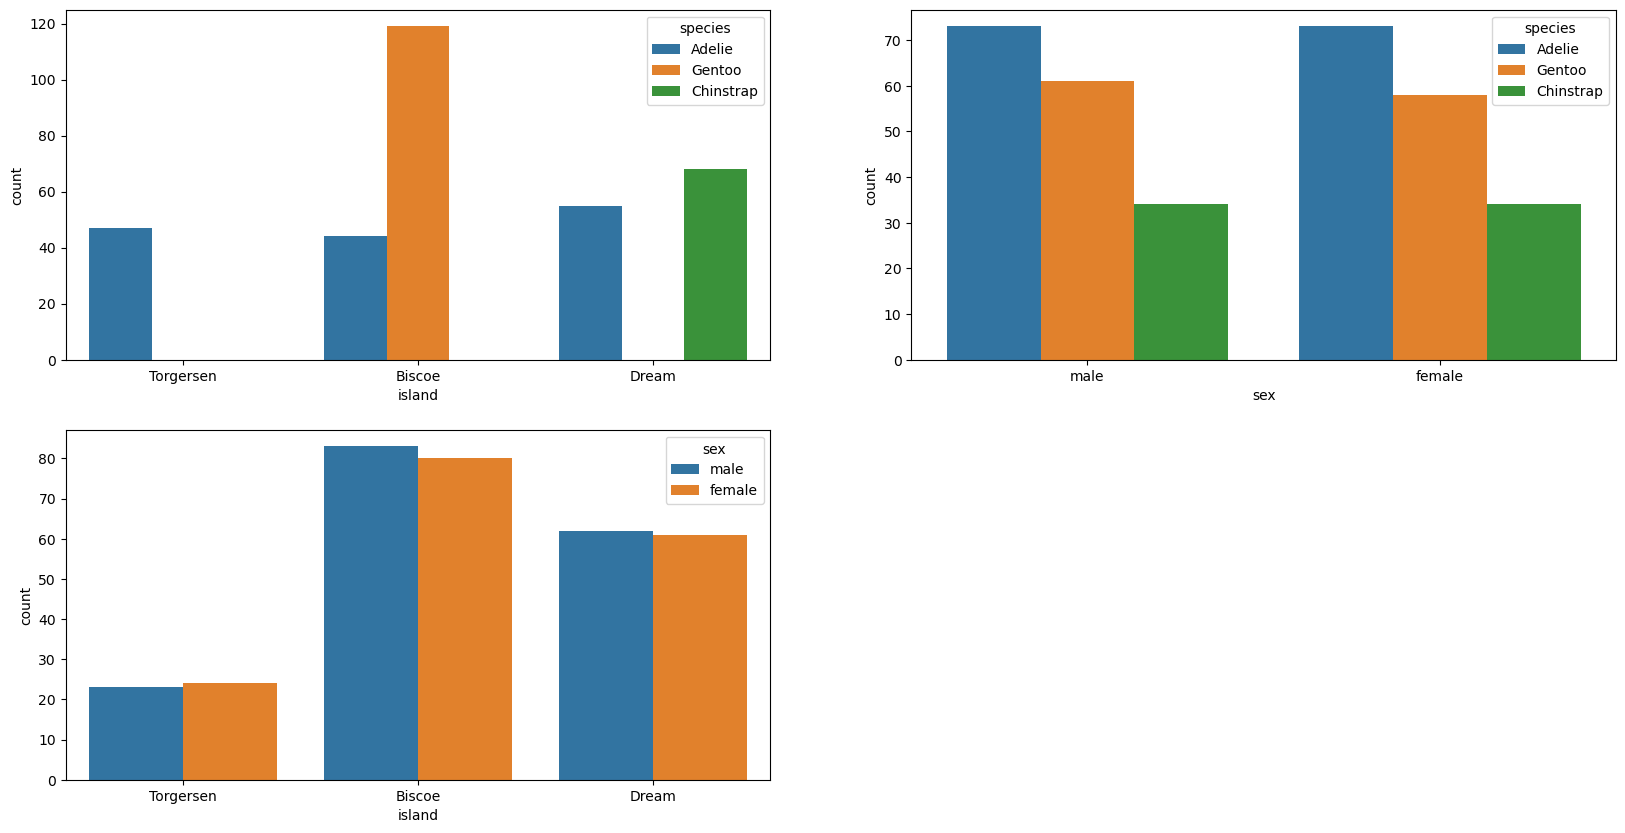

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
sns.countplot(x = "island",hue = "species",data = df)
plt.subplot(2,2,2)
sns.countplot(x = "sex",hue = "species",data = df)
plt.subplot(2,2,3)
sns.countplot(x = "island",hue = "sex",data = df)


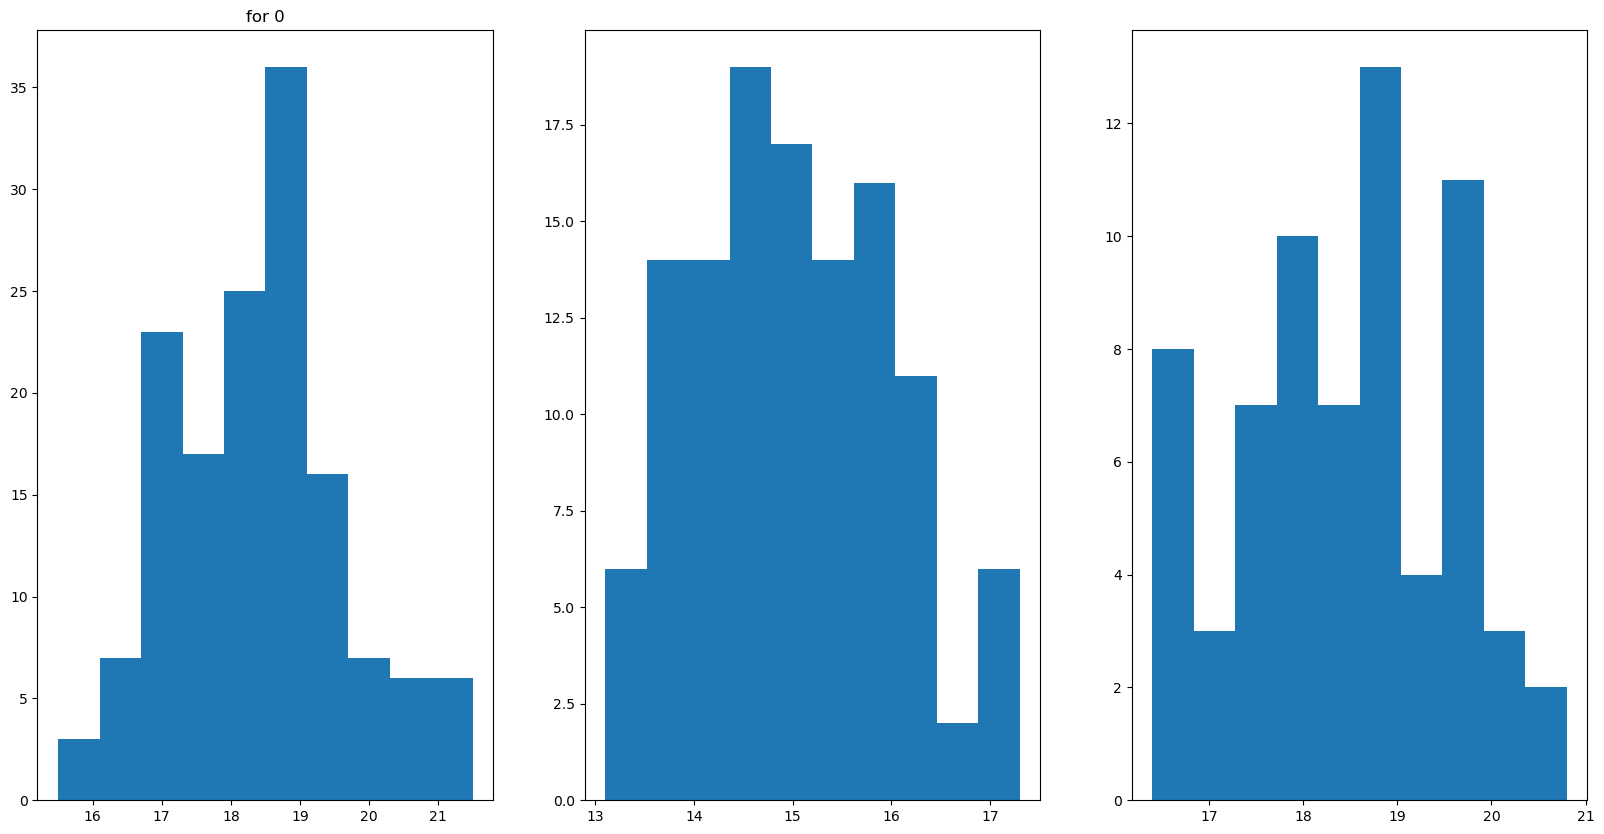

In [13]:
plt.figure(figsize = (20,10))
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# axs  = axs.flatten()/
plt.subplot(1,3,1)
plt.hist(x = "bill_depth_mm",data = df[df["species"] == "Adelie"])
plt.title("for 0")
plt.subplot(1,3,2)
plt.hist(x = "bill_depth_mm",data = df[df["species"] == "Gentoo"])
plt.subplot(1,3,3)
plt.hist(x = "bill_depth_mm",data = df[df["species"] == "Chinstrap"])
# plt.hist(x = "bill_length_mm",hue = "species",data = df[df["species"] == 1])
plt.show()

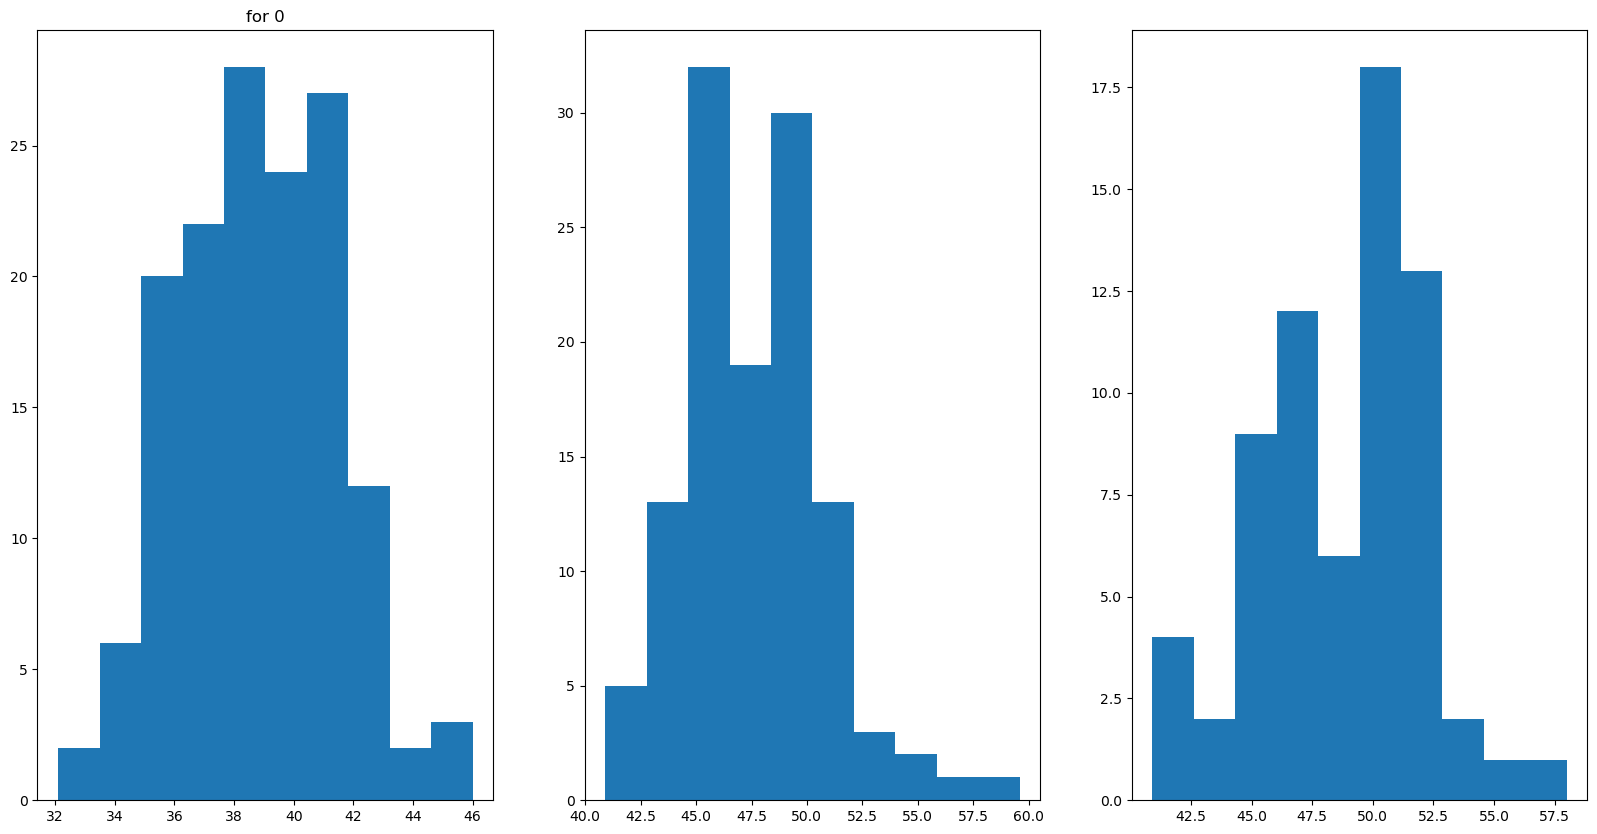

In [14]:
plt.figure(figsize = (20,10))
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# axs  = axs.flatten()/
plt.subplot(1,3,1)
plt.hist(x = "bill_length_mm",data = df[df["species"] == "Adelie"])
plt.title("for 0")
plt.subplot(1,3,2)
plt.hist(x = "bill_length_mm",data = df[df["species"] == "Gentoo"])
plt.subplot(1,3,3)
plt.hist(x = "bill_length_mm",data = df[df["species"] == "Chinstrap"])
# plt.hist(x = "bill_length_mm",hue = "species",data = df[df["species"] == 1])
plt.show()

In [15]:
df["species"].unique()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

In [16]:
df["island"].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [17]:
df.sex.unique()

array(['male', 'female'], dtype=object)

In [18]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
df["species"] =  le1.fit_transform(df["species"])
le2 = LabelEncoder()
df["island"] = le2.fit_transform(df["island"])
df["sex"] = le2.fit_transform(df["sex"])
le3 = LabelEncoder()
df["year"] = le3.fit_transform(df["year"])

In [19]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,sex,year
0,0,2,39.1,18.7,181.0,1,0
1,0,2,39.5,17.4,186.0,0,0
2,0,2,40.3,18.0,195.0,0,0
4,0,2,36.7,19.3,193.0,0,0
5,0,2,39.3,20.6,190.0,1,0


Functions for gini index


In [20]:
# gini index for a node

def giniofnode(l):
    total = np.sum(l)
    gini = 1
    for i in l :
        gini = gini + (-((i/total)**2))
    return gini
# sum of weighted gini index
def ginioflevel(l):
    gini = 0
    total = 0;
    for i in l:
        total += np.sum(i)
    for i in l:
        gini = gini + (np.sum(i)/total)*giniofnode(i)
    return gini


# level = [[1,2,1],[1,1,1]]
# print(ginioflevel(level))         

In [21]:
from sklearn.model_selection import train_test_split
X = df.drop("species",axis = 1)
y = df["species"]
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.20)

In [22]:
x_train.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,sex,year
207,0,45.0,15.4,220.0,1,1
325,1,49.8,17.3,198.0,0,2
157,0,46.5,13.5,210.0,0,0
96,1,38.1,18.6,190.0,0,1
160,0,43.3,13.4,209.0,0,0


In [23]:
y_train.head()

207    2
325    1
157    2
96     0
160    2
Name: species, dtype: int32

In [24]:
def find_thresh(x,y):
#     x,y list
    m = np.mean(x)
    threshold = np.min(x)
    step = m/10
#     level = [[0,0],[0,0]] #binary
    split = [0,0]
    bestthreshold = 0
    bestgini = -10
    while(threshold < np.max(x)):
        for i in range(len(x)):
            if(x[i] < threshold):
                split[0] += 1
            if(x[i] >= threshold):
                split[1] += 1
        currgini = giniofnode(split)
        if(abs(bestgini - 0.5) > abs(currgini - 0.5)):
            bestgini = currgini
            bestthreshold = threshold
        threshold += step
        print(split)
        split = [0,0]
    return bestthreshold,bestgini
def count_to_cat(x,y):
    thresh,gini = find_thresh(list(x),list(y))
    print(thresh,gini)
    l = []
    for i in list(x):
        if( i < thresh):
            l.append(0)
        else:
            l.append(1)
    return l
    


    

In [25]:
x_train["bill_length_mm"] = (count_to_cat(x_train["bill_length_mm"],y_train))
x_train["bill_depth_mm"] = (count_to_cat(x_train["bill_depth_mm"],y_train))
x_train["flipper_length_mm"] = (count_to_cat(x_train["flipper_length_mm"],y_train))

[0, 266]
[24, 242]
[87, 179]
[144, 122]
[215, 51]
[261, 5]
45.3415037593985 0.4965797953530444
[0, 266]
[43, 223]
[100, 166]
[169, 97]
[244, 22]
16.544511278195486 0.4692181581773984
[0, 266]
[90, 176]
[195, 71]
192.1327067669173 0.44773588105602363


In [26]:
x_train.head()
# x_train = x_train.drop("year",axis = 1)

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,sex,year
207,0,0,0,1,1,1
325,1,1,1,1,0,2
157,0,1,0,1,0,0
96,1,0,1,0,0,1
160,0,0,0,1,0,0


In [27]:
x_train.index = [i for i in range(len(x_train))]
y_train.index = [i for i in range(len(x_train))]
y_train[104]

1

In [77]:
# head = node(None,5,x_train,y_train)
# head = Train_tree(head)
clf = DecisionTreeClassifier(5)
clf.fit_train(x_train,y_train)

C:\Users\vidit\AppData\Local\Temp\ipykernel_20400\2528277565.py:7: RuntimeWarning: invalid value encountered in long_scalars
  gini = gini + (-((i/total)**2))
C:\Users\vidit\AppData\Local\Temp\ipykernel_20400\2528277565.py:7: RuntimeWarning: invalid value encountered in long_scalars
  gini = gini + (-((i/total)**2))
C:\Users\vidit\AppData\Local\Temp\ipykernel_20400\2528277565.py:7: RuntimeWarning: invalid value encountered in long_scalars
  gini = gini + (-((i/total)**2))
C:\Users\vidit\AppData\Local\Temp\ipykernel_20400\2528277565.py:7: RuntimeWarning: invalid value encountered in long_scalars
  gini = gini + (-((i/total)**2))
C:\Users\vidit\AppData\Local\Temp\ipykernel_20400\2528277565.py:7: RuntimeWarning: invalid value encountered in long_scalars
  gini = gini + (-((i/total)**2))
C:\Users\vidit\AppData\Local\Temp\ipykernel_20400\2528277565.py:7: RuntimeWarning: invalid value encountered in long_scalars
  gini = gini + (-((i/total)**2))
C:\Users\vidit\AppData\Local\Temp\ipykernel_20

In [78]:
predicted_values = clf.predict(x_test)

In [79]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print(accuracy_score(y_test,predicted_values))
print(classification_report(y_test,predicted_values))

0.7014925373134329
              precision    recall  f1-score   support

           0       1.00      0.35      0.52        31
           1       0.54      1.00      0.70        14
           2       0.73      1.00      0.85        22

    accuracy                           0.70        67
   macro avg       0.76      0.78      0.69        67
weighted avg       0.82      0.70      0.67        67



In [75]:
print(confusion_matrix(y_test,predicted_values))

[[11 12  8]
 [ 0 14  0]
 [ 0  0 22]]
